## StationaryPFR

Plug flow reactor in steady state operation.



In [16]:
import numpy as np

import matplotlib.pyplot as plt

import reactord as rd

### Operating the PFR

A reactor may be operated in terms of its catalyst operation, thermal operation, 
and pressure operation.


| Catalyst operation | Thermal opration | Pressure operation |
|--------------------|------------------|--------------------|
| Homogeneous        | Isothermal       | Isobaric           |
| Heterogeneous      | Adiabatic        | Non-isobaric       |
|                    | Non-isothermal   |                    |



For the piston flow reactor, the list of implemented operations is:

- Homogeneous  
    - Isothermal  
        - Isobaric
        - Non-isobaric  
    - Adiabatic  
        - Isobaric  
        - Non-isobaric  

### Specifying a kinetic law

#### Stoichiometry matrix

Imagine for a moment a system with multiple reactions (3 reactions):

Reaction 1: $$A + B \rightarrow C + D$$
Reaction 2: $$2B \leftrightarrow E$$
Reaction 3: $$E + 2A \rightarrow 3F$$

And you have defined in the mixture (see [Mixtures tutorial](../mix/mix_index.rst))
the substances in the order A, B, C, D, E, F. E.g:

```python
mixture = rd.mix.IdealGas(A=A, B=B, C=C, D=D, E=E, F=F)
```

Then the stoichiometry matrix is:

|            	|  A 	|  B 	|  C 	|  D 	|  E 	|  F 	|
|------------	|----	|----	|----	|----	|----	|----	|
| reaction 1 	| -1 	| -1 	|  1 	|  1 	|  0 	|  0 	|
| reaction 2 	|  0 	| -2 	|  0 	|  0 	|  1 	|  0 	|
| reaction 3 	| -2 	|  0 	|  0 	|  0 	| -1 	|  3 	|

For ReactorD the matrix is loaded from a numpy matrix:

```python
stoichiometry = np.array(
    [
        [-1, -1, 1, 1, 0, 0],
        [0, -2, 0, 0, 1, 0],
        [-2, 0, 0, 0, -1, 3],
    ]
)
```




#### Reaction rate

Reaction rates are defined by python function with the format:

```python
def reaction_rate(composition: np.ndarray, temperature: float) -> float:
    # calculation of the reaction rate 
    return evaluated_reaction_rate
```

Composition is the compositional argument of the reaction_rate. The available
compositional arguments in ReactorD are:  

- Concentration $[\frac {mol} {m^3}]$  
- Partial pressure [Pa]

The desired compositional argument is selected in the reactor's definition with
the argument "kinetic_argument". 

If Concentrationtion is selected as the compositional argument, ReactorD will 
evaluate the ```reaction_rate``` in the concentrations of all the mixture's
substances and the temperature. Then, for the previous 3 hypothetical reactions
the reaction rates could be.

Note: remember that the order of the substances in the mix is: A, B, C, D, E, F

```python
def reaction_rate_1(composition, temperature):
    c = composition # all concentrations stored in variable c
    k_1 = 0.001 * np.exp(-10000 / temperature) # Arrhenius kinetic constant

    reaction_rate_1 = k_1 * c[0] * c[1]
    return reaction_rate_1


def reaction_rate_2(composition, temperature):
    c = composition # all concentrations stored in variable c
    k_2_d = 0.002 * np.exp(-12000 / temperature) # direct reaction constant
    k_2_i = 0.0008 * np.exp(-9000 / temperature) # reverse reaction constant

    reaction_rate_2 = k_2_d * c[1]**2 - k_2_i c[4]
    return reaction_rate_2


def reaction_rate_3(composition, temperature):
    c = composition # all concentrations stored in variable c
    k_3 = 0.0005 * np.exp(-5000 / temperature) # Arrhenius kinetic constant

    reaction_rate_3 = k_3 * c[4] * c[1]**2
    return reaction_rate_3
```

#### Example: P1.15a Fogler's 4th ed.

Reaction:

$$A \rightarrow B$$

Kinetic law:

$$r = kC_{A}$$

Initial mole fluxe of the reagent A =  0.0013889 $\frac {mol}{s}$  
Kinetic constant = 0.013889 $\frac {mol} {s·m^3}$  
PFR's volume = 0.099 $m^3$  
Volumetric (and constat) flow = 0.0001667 $\frac {m^3} {s}$


Reactor: the liquid phase, Isothermic and isobaric PFR
Temperature not specified. It is assumed as 298.15 K (temperature will not be 
used) Pressure not specified. It is assumed as 101325 Pa (pressure will not be 
used)

__Substance definitions__  

For a liquid phase, isothermic and isobaric PFR only the volume of the pure
substances is necessary to evaluate the mass balance.

In [17]:
def volume(temperature, pressure):
    return 1 / (fa_in / f_volumetric)


# Problems data

fa_in = 0.0013889  # mol/s
k = 0.013889  # mol/m3/s
v_pfr = 0.099  # m3
f_volumetric = 0.0001667  # m3/s

# Substance definition
A = rd.Substance(name="A", volume_liquid=volume)
B = rd.Substance(name="B", volume_liquid=volume)

__Mixture definition__

In [18]:
mixture = rd.mix.IdealSolution(A=A, B=B)

__Kinetic definition__  



In [19]:
stoichiometry_matrix = np.array(
    [
        [-1, 1],
    ]
)


def reaction_rate(composition, temperature):
    return k * composition[0]

__Reactor set__

Since the reactor is isothermic and isobaric, we call the construction method 
for the isothermal and isobaric operation. 

In [20]:
pfr = rd.idealreactor.StationaryPFR.from_isothermic_isobaric(
    mix=mixture,
    list_of_reactions=[reaction_rate],
    stoichiometry=stoichiometry_matrix,
    kinetic_argument="concentration",
    reactor_dim_minmax=[0, v_pfr],
    transversal_area=1,
    isothermic_temperature=298.15,
    isobaric_pressure=101325,
    molar_flow_in={"A": fa_in, "B": 0},
)

__Simulate the reactor__

In [21]:
simulation_result = pfr.simulate(
    grid_size=100,
    tol=0.001,
    max_nodes=1000,
)

__Ploting results__

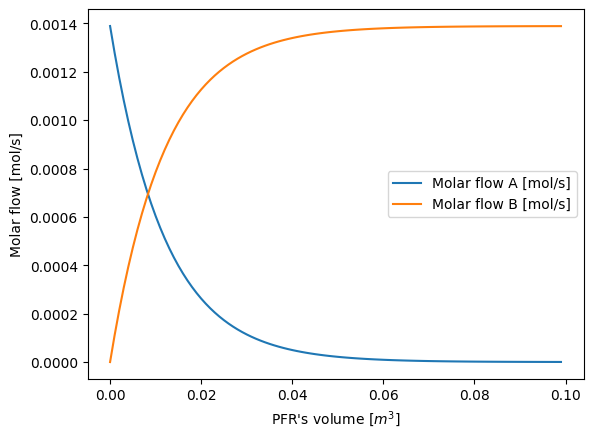

In [22]:
reactor_volume_nodes = simulation_result.x

dependent_variables = simulation_result.y

molar_flow_A = dependent_variables[0, :]
molar_flow_B = dependent_variables[1, :]
temperature = dependent_variables[2, :]
pressure = dependent_variables[3, :]

plt.plot(reactor_volume_nodes, molar_flow_A, label="Molar flow A [mol/s]")
plt.plot(reactor_volume_nodes, molar_flow_B, label="Molar flow B [mol/s]")

plt.xlabel("PFR's volume $[m^3]$")
plt.ylabel("Molar flow [mol/s]")

plt.legend()
plt.show()